<a href="https://colab.research.google.com/github/ngtuanduy12/bank-marketing-analysis-customer-subscription/blob/main/notebook/bank_marketing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip install chefboost imbalanced-learn -q
!pip install scikit-learn matplotlib graphviz

import pandas as pd
from chefboost import Chefboost as chef
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image

if not os.path.exists('output'):
    os.makedirs('output')

print("✅ Đã cài đặt và import thư viện thành công!")

✅ Đã cài đặt và import thư viện thành công!


In [ ]:

## GIAI ĐOẠN 2: TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU

print("=== TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU ===")

# Tải dữ liệu
df = pd.read_csv('bank-additional-full.csv', sep=';')
print("Kích thước dữ liệu gốc:", df.shape)

# Loại bỏ cột duration
df = df.drop('duration', axis=1)
print(f"Kích thước sau khi xóa cột duration: {df.shape}")

# Đảm bảo cột mục tiêu 'y' là cột cuối cùng
if df.columns[-1] != 'y':
    cols = [col for col in df.columns if col != 'y'] + ['y']
    df = df[cols]

print("✅ Đã tải và tiền xử lý dữ liệu thành công!")

=== TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU ===
Kích thước dữ liệu gốc: (41188, 21)
Kích thước sau khi xóa cột duration: (41188, 20)
✅ Đã tải và tiền xử lý dữ liệu thành công!


In [ ]:
## GIAI ĐOẠN 3: MÃ HÓA DỮ LIỆU

print("\n=== MÃ HÓA DỮ LIỆU ===")

def prepare_data(df):
    df_encoded = df.copy()
    categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                           'contact', 'month', 'day_of_week', 'poutcome']

    le = LabelEncoder()
    for col in categorical_columns:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        print(f"✅ Đã mã hóa cột: {col}")

    df_encoded['y'] = df_encoded['y'].map({'no': 0, 'yes': 1})
    return df_encoded

df_encoded = prepare_data(df)


X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

print("\nPhân phối gốc:")
print(f"Lớp 0 ('no'): {sum(y == 0):,} mẫu")
print(f"Lớp 1 ('yes'): {sum(y == 1):,} mẫu")
print(f"Tỷ lệ lớp thiểu số: {sum(y == 1) / len(y) * 100:.2f}%")



=== MÃ HÓA DỮ LIỆU ===
✅ Đã mã hóa cột: job
✅ Đã mã hóa cột: marital
✅ Đã mã hóa cột: education
✅ Đã mã hóa cột: default
✅ Đã mã hóa cột: housing
✅ Đã mã hóa cột: loan
✅ Đã mã hóa cột: contact
✅ Đã mã hóa cột: month
✅ Đã mã hóa cột: day_of_week
✅ Đã mã hóa cột: poutcome

Phân phối gốc:
Lớp 0 ('no'): 36,548 mẫu
Lớp 1 ('yes'): 4,640 mẫu
Tỷ lệ lớp thiểu số: 11.27%


In [ ]:
## GIAI ĐOẠN 4: CHIA DỮ LIỆU GỐC THÀNH TRAIN/TEST

print("\n=== CHIA DỮ LIỆU GỐC ===")

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Kích thước tập huấn luyện gốc: {X_train_orig.shape}")
print(f"Kích thước tập kiểm tra gốc: {X_test_orig.shape}")

# Phân phối tập train gốc
print("\nPhân phối tập TRAIN gốc:")
train_orig_class_1_pct = round(sum(y_train_orig == 1) / len(y_train_orig) * 100, 2)
train_orig_dist = pd.DataFrame({
    'Dataset': ['Train Original'],
    'Class_0_Count': [sum(y_train_orig == 0)],
    'Class_1_Count': [sum(y_train_orig == 1)],
    'Class_1_Percentage': [train_orig_class_1_pct]
})
print(train_orig_dist)


=== CHIA DỮ LIỆU GỐC ===
Kích thước tập huấn luyện gốc: (32950, 19)
Kích thước tập kiểm tra gốc: (8238, 19)

Phân phối tập TRAIN gốc:
          Dataset  Class_0_Count  Class_1_Count  Class_1_Percentage
0  Train Original          29238           3712               11.27


In [ ]:
## GIAI ĐOẠN 5: ÁP DỤNG SMOTE_50

print("\n=== ÁP DỤNG SMOTE_50 ===")
categorical_features = [X_train_orig.columns.get_loc(col) for col in ['job','marital','education',
                                                                      'default','housing','loan',
                                                                      'contact','month','day_of_week','poutcome']]

smote_nc = SMOTENC(categorical_features=categorical_features,
                   random_state=42, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train_orig, y_train_orig)

print("Phân phối sau SMOTE trên TRAIN:")
print(f"Lớp 0 ('no'): {sum(y_train_smote == 0):,} mẫu")
print(f"Lớp 1 ('yes'): {sum(y_train_smote == 1):,} mẫu")
print(f"Tỷ lệ lớp 1: {sum(y_train_smote == 1) / len(y_train_smote) * 100:.2f}%")



=== ÁP DỤNG SMOTE_50 ===
Phân phối sau SMOTE trên TRAIN:
Lớp 0 ('no'): 29,238 mẫu
Lớp 1 ('yes'): 14,619 mẫu
Tỷ lệ lớp 1: 33.33%


In [ ]:
print("\n=== GIAI ĐOẠN 6: TỔNG HỢP DỮ LIỆU TRAIN/TEST SAU SMOTE ===")

print(f"Kích thước tập TRAIN sau SMOTE: {X_train_smote.shape}")
print(f"Kích thước tập TEST giữ nguyên: {X_test_orig.shape}")

# Phân phối tập train sau SMOTE
train_smote_class_1_pct = round(sum(y_train_smote == 1) / len(y_train_smote) * 100, 2)
train_smote_dist = pd.DataFrame({
    'Dataset': ['Train After SMOTE'],
    'Class_0_Count': [sum(y_train_smote == 0)],
    'Class_1_Count': [sum(y_train_smote == 1)],
    'Class_1_Percentage': [train_smote_class_1_pct]
})
print("\nPhân phối tập TRAIN sau SMOTE:")
print(train_smote_dist)



=== GIAI ĐOẠN 6: TỔNG HỢP DỮ LIỆU TRAIN/TEST SAU SMOTE ===
Kích thước tập TRAIN sau SMOTE: (43857, 19)
Kích thước tập TEST giữ nguyên: (8238, 19)

Phân phối tập TRAIN sau SMOTE:
             Dataset  Class_0_Count  Class_1_Count  Class_1_Percentage
0  Train After SMOTE          29238          14619               33.33


In [ ]:
print("\n=== GIAI ĐOẠN 7: SO SÁNH PHÂN PHỐI DỮ LIỆU ===")

comparison_df = pd.DataFrame({
    'Dataset': ['Original', 'Train Original', 'Train After SMOTE', 'Test Original'],
    'Total_Samples': [
        len(y),
        len(y_train_orig),
        len(y_train_smote),
        len(y_test_orig)
    ],
    'Class_0_Count': [
        sum(y == 0),
        sum(y_train_orig == 0),
        sum(y_train_smote == 0),
        sum(y_test_orig == 0)
    ],
    'Class_1_Count': [
        sum(y == 1),
        sum(y_train_orig == 1),
        sum(y_train_smote == 1),
        sum(y_test_orig == 1)
    ],
    'Class_1_Percentage': [
        round(sum(y == 1) / len(y) * 100, 2),
        round(sum(y_train_orig == 1) / len(y_train_orig) * 100, 2),
        round(sum(y_train_smote == 1) / len(y_train_smote) * 100, 2),
        round(sum(y_test_orig == 1) / len(y_test_orig) * 100, 2)
    ]
})

print(comparison_df)



=== GIAI ĐOẠN 7: SO SÁNH PHÂN PHỐI DỮ LIỆU ===
             Dataset  Total_Samples  Class_0_Count  Class_1_Count  \
0           Original          41188          36548           4640   
1     Train Original          32950          29238           3712   
2  Train After SMOTE          43857          29238          14619   
3      Test Original           8238           7310            928   

   Class_1_Percentage  
0               11.27  
1               11.27  
2               33.33  
3               11.26  


In [ ]:
## GIAI ĐOẠN 8: CHUẨN BỊ DỮ LIỆU CHO CHEFBOOST

print("\n=== CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH ===")

def prepare_for_chefboost(X, y):
    df_chef = X.copy()
    df_chef['y'] = y.map({0: 'no', 1: 'yes'})

    categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                           'contact', 'month', 'day_of_week', 'poutcome']
    for col in categorical_columns:
        df_chef[col] = df_chef[col].astype(int).astype(str)  # Đảm bảo là số nguyên trước khi chuyển thành string

    return df_chef

print("\n=== CHUẨN BỊ DỮ LIỆU CHO CHEFBOOST (TRƯỚC SMOTE) ===")

# Chuẩn bị dữ liệu train/test trước khi SMOTE
train_df_orig = prepare_for_chefboost(X_train_orig, y_train_orig)
test_df_orig = prepare_for_chefboost(X_test_orig, y_test_orig)

print("Kích thước train trước SMOTE:", train_df_orig.shape)
print("Kích thước test trước SMOTE:", test_df_orig.shape)

# Chuẩn bị dữ liệu train/test cho Chefboost
train_df = prepare_for_chefboost(X_train_smote, y_train_smote)
test_df = prepare_for_chefboost(X_test_orig, y_test_orig)

print("✅ Đã chuẩn bị dữ liệu cho Chefboost thành công!")
print(f"Kích thước tập train: {train_df.shape}")
print(f"Kích thước tập test: {test_df.shape}")


=== CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH ===

=== CHUẨN BỊ DỮ LIỆU CHO CHEFBOOST (TRƯỚC SMOTE) ===
Kích thước train trước SMOTE: (32950, 20)
Kích thước test trước SMOTE: (8238, 20)
✅ Đã chuẩn bị dữ liệu cho Chefboost thành công!
Kích thước tập train: (43857, 20)
Kích thước tập test: (8238, 20)


In [ ]:
## GIAI ĐOẠN 9: HUẤN LUYỆN MÔ HÌNH C4.5

# %%
print("\n=== HUẤN LUYỆN MÔ HÌNH C4.5 TRƯỚC SMOTE ===")

config_orig = {
    'algorithm': 'C4.5',
    'max_depth': 11,
    'min_samples': 30,
    'confidence': 0.15,
    'enableParallelism': False
}

print("Đang huấn luyện mô hình (trước SMOTE)...")
model_orig = chef.fit(train_df_orig, config=config_orig, target_label='y')
print("✅ Huấn luyện mô hình trước SMOTE hoàn tất!")


print("\n=== HUẤN LUYỆN MÔ HÌNH C4.5 VỚI SMOTE_50 ===")

config = {
    'algorithm': 'C4.5',
    'max_depth': 11,
    'min_samples': 30,
    'confidence': 0.15,
    'enableParallelism': False
}

print("Đang huấn luyện mô hình...")
model = chef.fit(train_df, config=config, target_label='y')
print("✅ Huấn luyện mô hình hoàn tất!")


=== HUẤN LUYỆN MÔ HÌNH C4.5 TRƯỚC SMOTE ===
Đang huấn luyện mô hình (trước SMOTE)...
25-11-28 03:37:53 - C4.5 tree is going to be built...
25-11-28 03:40:58 - -------------------------
25-11-28 03:40:58 - finished in 184.73515486717224 seconds
25-11-28 03:41:02 - -------------------------
25-11-28 03:41:02 - Evaluate train set
25-11-28 03:41:02 - -------------------------
25-11-28 03:41:02 - Accuracy: 90.74355083459787% on 32950 instances
25-11-28 03:41:02 - Labels: ['no' 'yes']
25-11-28 03:41:02 - Confusion matrix: [[28797, 2609], [441, 1103]]
25-11-28 03:41:02 - Precision: 91.6927%, Recall: 98.4917%, F1: 94.9707%
✅ Huấn luyện mô hình trước SMOTE hoàn tất!

=== HUẤN LUYỆN MÔ HÌNH C4.5 VỚI SMOTE_50 ===
Đang huấn luyện mô hình...
25-11-28 03:41:02 - C4.5 tree is going to be built...
25-11-28 03:42:55 - -------------------------
25-11-28 03:42:55 - finished in 112.94078135490417 seconds
25-11-28 03:43:00 - -------------------------
25-11-28 03:43:00 - Evaluate train set
25-11-28 03:43:0

In [ ]:
print("\n=== GIAI ĐOẠN 10: ĐÁNH GIÁ VÀ SO SÁNH 2 MÔ HÌNH (SỬ DỤNG CHỈ SỐ MACRO) ===")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_model(model, test_df, title):
    y_pred = []
    for _, instance in test_df.iterrows():
        prediction = chef.predict(model, instance)
        y_pred.append(prediction)

    y_true = test_df["y"].values
    y_pred = np.array(y_pred)

    # Tính chỉ số
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro    = recall_score(y_true, y_pred, average='macro')
    f1_macro        = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred, labels=['no', 'yes'])
    TN, FP, FN, TP = cm.ravel()

    # --- IN KẾT QUẢ ---
    print("\n" + "="*70)
    print(f"🎯 {title}")
    print("="*70)

    print(f"📊 Accuracy: {accuracy:.4f}\n")

    print("📌 CHỈ SỐ TRUNG BÌNH CÂN BẰNG (MACRO):")
    print(f"  • Precision_macro: {precision_macro:.4f}")
    print(f"  • Recall_macro   : {recall_macro:.4f}")
    print(f"  • F1_macro       : {f1_macro:.4f}\n")

    print("📊 MA TRẬN NHẦM LẪN:")
    print("                    Dự đoán 'no'    Dự đoán 'yes'")
    print(f"Thực tế 'no'      {TN:>10}        {FP:>10}")
    print(f"Thực tế 'yes'     {FN:>10}        {TP:>10}")

    return accuracy, precision_macro, recall_macro, f1_macro



# ======================== CHẠY ĐÁNH GIÁ 2 MÔ HÌNH ==============================

acc1, pre1, rec1, f1_1 = evaluate_model(model_orig, test_df_orig,
                                       "MÔ HÌNH C4.5 TRƯỚC SMOTE")

acc2, pre2, rec2, f1_2 = evaluate_model(model, test_df,
                                       "MÔ HÌNH C4.5 SAU SMOTE_50")

print("\n" + "="*70)
print("🔔 SO SÁNH TỔNG KẾT GIỮA 2 MÔ HÌNH trước smote và sau smote (CHỈ SỐ MACRO)")
print("="*70)

print(f"📌 Accuracy         : {acc1:.4f} (Trước)   | {acc2:.4f} (Sau)")
print(f"📌 Precision_macro  : {pre1:.4f} (Trước)   | {pre2:.4f} (Sau)")
print(f"📌 Recall_macro     : {rec1:.4f} (Trước)   | {rec2:.4f} (Sau)")
print(f"📌 F1_macro         : {f1_1:.4f} (Trước)   | {f1_2:.4f} (Sau)")






=== GIAI ĐOẠN 10: ĐÁNH GIÁ VÀ SO SÁNH 2 MÔ HÌNH (SỬ DỤNG CHỈ SỐ MACRO) ===

🎯 MÔ HÌNH C4.5 TRƯỚC SMOTE
📊 Accuracy: 0.9000

📌 CHỈ SỐ TRUNG BÌNH CÂN BẰNG (MACRO):
  • Precision_macro: 0.7754
  • Recall_macro   : 0.6200
  • F1_macro       : 0.6569

📊 MA TRẬN NHẦM LẪN:
                    Dự đoán 'no'    Dự đoán 'yes'
Thực tế 'no'            7174               136
Thực tế 'yes'            688               240

🎯 MÔ HÌNH C4.5 SAU SMOTE_50
📊 Accuracy: 0.8894

📌 CHỈ SỐ TRUNG BÌNH CÂN BẰNG (MACRO):
  • Precision_macro: 0.7214
  • Recall_macro   : 0.7034
  • F1_macro       : 0.7118

📊 MA TRẬN NHẦM LẪN:
                    Dự đoán 'no'    Dự đoán 'yes'
Thực tế 'no'            6897               413
Thực tế 'yes'            498               430

🔔 SO SÁNH TỔNG KẾT GIỮA 2 MÔ HÌNH trước smote và sau smote (CHỈ SỐ MACRO)
📌 Accuracy         : 0.9000 (Trước)   | 0.8894 (Sau)
📌 Precision_macro  : 0.7754 (Trước)   | 0.7214 (Sau)
📌 Recall_macro     : 0.6200 (Trước)   | 0.7034 (Sau)
📌 F1_macro         


=== CÂY VỚI FEATURE QUAN TRỌNG NHẤT ===
📈 TOP 10 FEATURE QUAN TRỌNG NHẤT:
           feature  importance
18     nr.employed    0.449726
17       euribor3m    0.128932
16   cons.conf.idx    0.105288
7          contact    0.048293
15  cons.price.idx    0.034018
13        poutcome    0.029758
12        previous    0.028387
0              age    0.027231
8            month    0.026283
6             loan    0.019722


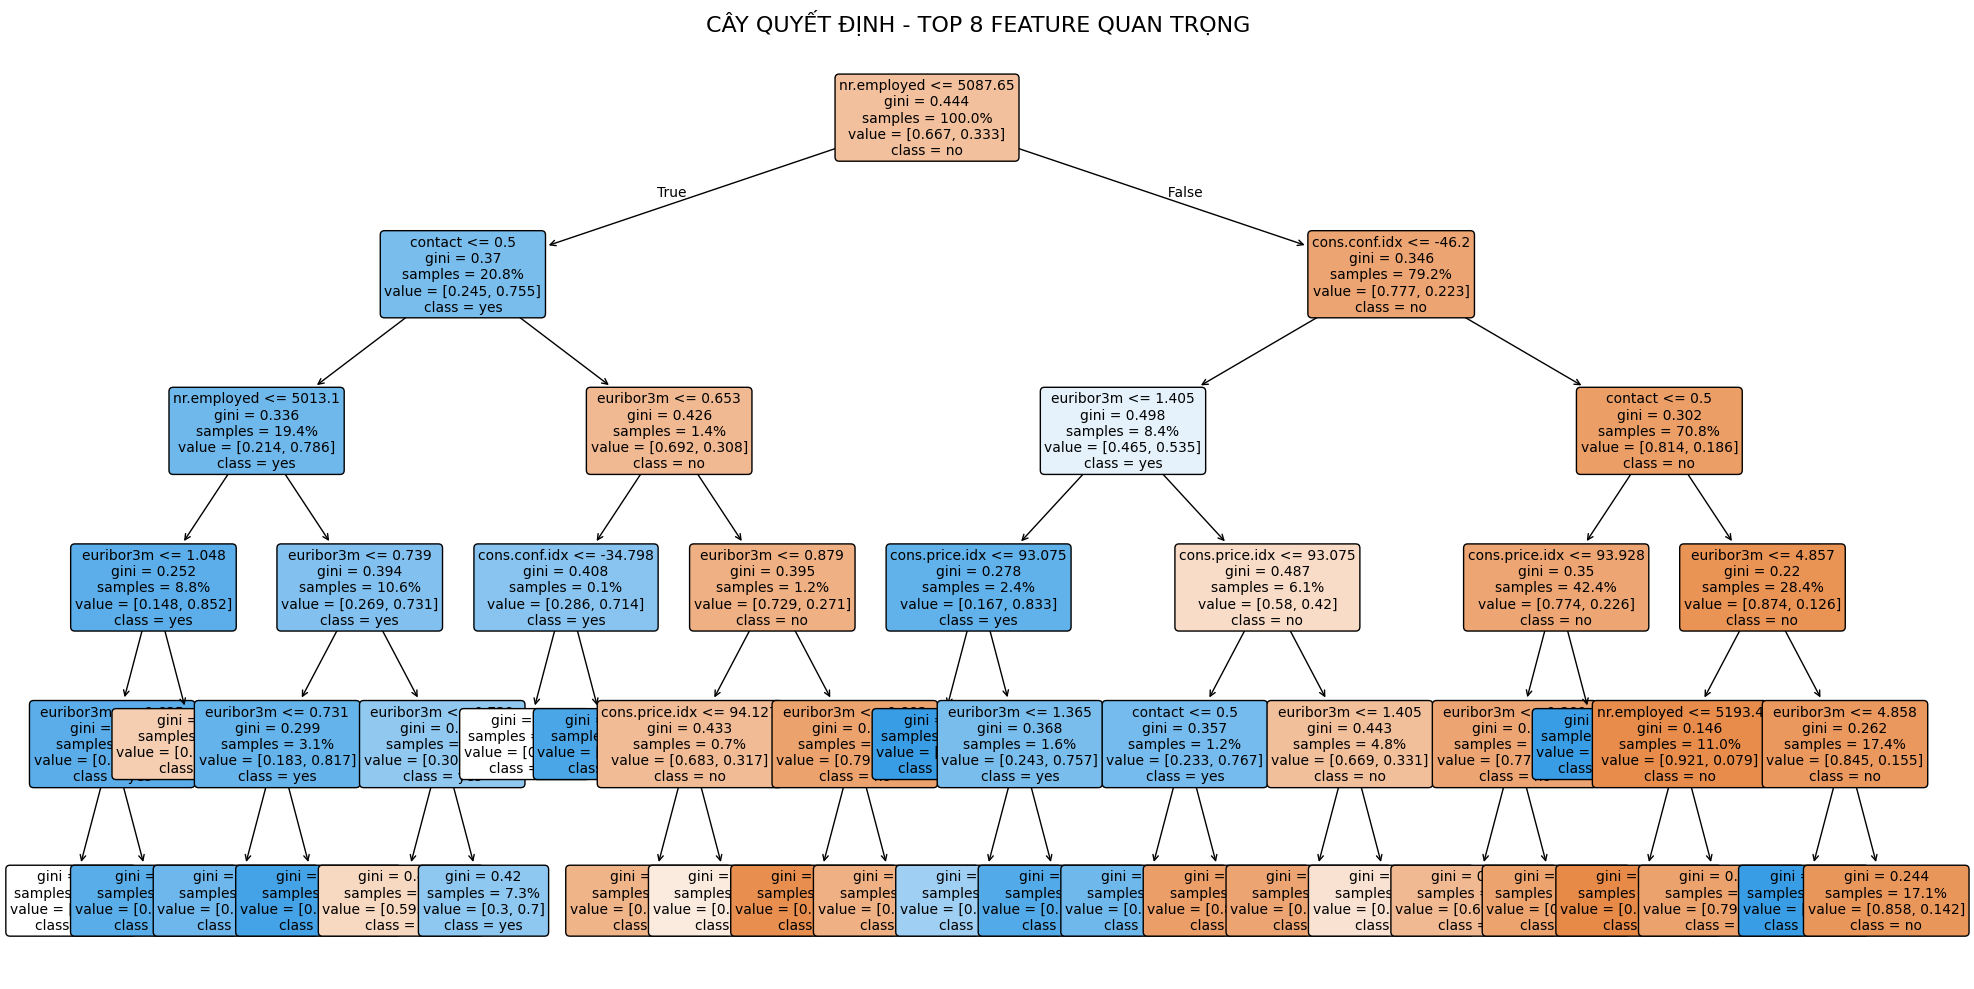

✅ Đã lưu cây top features: c45_tree_top_features.png


In [ ]:
# %%
# VẼ CÂY CHỈ VỚI CÁC FEATURE QUAN TRỌNG NHẤT
print("\n=== CÂY VỚI FEATURE QUAN TRỌNG NHẤT ===")

try:
    # Lấy feature importance
    importances = sklearn_dt.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("📈 TOP 10 FEATURE QUAN TRỌNG NHẤT:")
    print(feature_imp_df.head(10))

    # Chọn top 8 features quan trọng nhất
    top_features = feature_imp_df.head(5)['feature'].tolist()
    top_feature_indices = [feature_names.index(f) for f in top_features]

    # Huấn luyện cây mới chỉ với top features
    X_train_top = X_train[top_features]

    sklearn_dt_top = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=30,
        min_samples_leaf=15,
        random_state=42
    )

    sklearn_dt_top.fit(X_train_top, y_train)

    # Vẽ cây chỉ với top features
    plt.figure(figsize=(20, 10))
    tree.plot_tree(sklearn_dt_top,
                   feature_names=top_features,
                   class_names=['no', 'yes'],
                   filled=True,
                   rounded=True,
                   fontsize=10,
                   proportion=True)

    plt.title('CÂY QUYẾT ĐỊNH - TOP 8 FEATURE QUAN TRỌNG', fontsize=16)
    plt.tight_layout()
    plt.savefig('c45_tree_top_features.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Đã lưu cây top features: c45_tree_top_features.png")

except Exception as e:
    print(f"❌ Lỗi khi vẽ cây top features: {e}")

In [ ]:
# -*- coding: utf-8 -*-
"""LƯU MÔ HÌNH DECISION TREE HOÀN CHỈNH"""

import joblib
from google.colab import files
import pandas as pd
from sklearn.preprocessing import LabelEncoder

print("=== LƯU MÔ HÌNH DECISION TREE ===")

# 1. Lưu mô hình với joblib (scikit-learn models work perfectly)
joblib.dump(model, 'decision_tree_model.pkl')
print("✅ Đã lưu mô hình: decision_tree_model.pkl")

# 2. Lưu bộ mã hóa
label_encoders = {}
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                       'contact', 'month', 'day_of_week', 'poutcome', 'y']

for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(df[col].astype(str))
        label_encoders[col] = le
        print(f"✅ Đã tạo encoder cho: {col}")

joblib.dump(label_encoders, 'label_encoders.pkl')
print("✅ Đã lưu bộ mã hóa: label_encoders.pkl")

# 3. Lưu danh sách features (rất quan trọng)
feature_names = list(X.columns)
joblib.dump(feature_names, 'feature_names.pkl')
print("✅ Đã lưu danh sách features: feature_names.pkl")

# 4. Tải tất cả file về
print("\n📥 Đang tải file về máy...")
files.download('decision_tree_model.pkl')
files.download('label_encoders.pkl')
files.download('feature_names.pkl')

print("\n🎉 ĐÃ HOÀN TẤT! 3 file đã được tải về:")
print("   - decision_tree_model.pkl")
print("   - label_encoders.pkl")
print("   - feature_names.pkl")


=== LƯU MÔ HÌNH DECISION TREE ===
✅ Đã lưu mô hình: decision_tree_model.pkl
✅ Đã tạo encoder cho: job
✅ Đã tạo encoder cho: marital
✅ Đã tạo encoder cho: education
✅ Đã tạo encoder cho: default
✅ Đã tạo encoder cho: housing
✅ Đã tạo encoder cho: loan
✅ Đã tạo encoder cho: contact
✅ Đã tạo encoder cho: month
✅ Đã tạo encoder cho: day_of_week
✅ Đã tạo encoder cho: poutcome
✅ Đã tạo encoder cho: y
✅ Đã lưu bộ mã hóa: label_encoders.pkl
✅ Đã lưu danh sách features: feature_names.pkl

📥 Đang tải file về máy...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 ĐÃ HOÀN TẤT! 3 file đã được tải về:
   - decision_tree_model.pkl
   - label_encoders.pkl
   - feature_names.pkl
